# Combine the axisymmetric bias in kinematics for prolate and oblate population

In './axi_vs_sph_jam.ipynb' we calculated the bias between aixsymmetric and spherical JAM for both the oblate and prolate population. In this notebook we combine them using the oblate-to-prolate ratio inferred from the lens population in Knabel et al 2024 (K24). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

from copy import deepcopy

from hierarc.Util.distribution_util import PDFSampling


Misalignment angle measured in K24:

In [2]:
obj_names = ['SDSSJ0029-0055', 'SDSSJ0037-0942', 'SDSSJ0330-0020',
       'SDSSJ1112+0826', 'SDSSJ1204+0358', 'SDSSJ1250+0523',
       'SDSSJ1306+0600', 'SDSSJ1402+6321', 'SDSSJ1531-0105',
       'SDSSJ1538+5817', 'SDSSJ1621+3931', 'SDSSJ1627-0053',
       'SDSSJ1630+4520', 'SDSSJ2303+1422']

misalignment = np.array([31. , 28. , 34. ,  3., 14. , 71., 35. , 19.,  9., 19. ,  9. ,
       14.,  5., 12.])

misalignment_err = np.array([30.,  4., 10.,  3., 11.,  7., 13.,  8., 30., 30.,  4., 13.,  9.,
       30.])

## Infer oblate ratio in the oerall populationusing misalignment angle.

In the following we calculate the likelihood of the data as a function of f, where f is the fraction of oblates and 1-f is the fraction of prolates. 

The likelihood function can be written as: 

\begin{equation}
L(\Delta \phi_i \vert f) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot [f  \exp(-\frac{\Delta \phi_i^2}{2\sigma^2}) + (1 - f) \exp(-\frac{(\Delta \phi_i - 90)^2}{2\sigma^2})],
\end{equation}
for an individual data point.

In [3]:
# use one data point as an example

def LikelihoodIndividual(misalignment, misalignment_err, f_array):
    likelihood_array = np.full_like(f_array, np.nan)
    for i, f in enumerate(f_array):
        likelihood_array[i] = (f * np.exp(-misalignment**2 / 2 / misalignment_err**2) + (1 - f) * np.exp(-(misalignment-90)**2 / 2 / misalignment_err**2)) / np.sqrt(2 * np.pi * misalignment_err**2)
    norm = np.trapz(likelihood_array, f_array)
    likelihood_array = likelihood_array / norm
    return likelihood_array

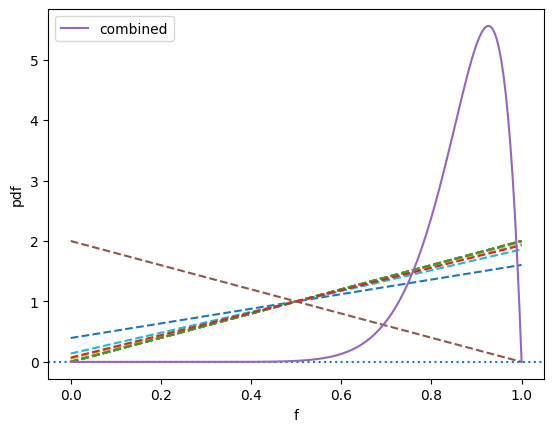

In [4]:
f_array = np.linspace(0, 1, 200)
likelihood_all = []
for i in range(len(misalignment)):
    likelihood_individual = LikelihoodIndividual(misalignment[i], misalignment_err[i], f_array)
    likelihood_all.append(likelihood_individual)
    plt.plot(f_array, likelihood_individual, ls = '--')

likelihood_all = np.array(likelihood_all)
likelihood_combined = np.prod(likelihood_all, axis=0)
norm = np.trapz(likelihood_combined, f_array)
likelihood_combined = likelihood_combined / norm
plt.axhline(0, ls = ':')
plt.plot(f_array, likelihood_combined, label = 'combined')
plt.xlabel('f')
plt.ylabel('pdf')
plt.legend()

## Combine the bias for the oblate and prolate by marginalising over $f$

In [5]:
beta_const_list = [-0.2, 0, 0.2]

data_oblate = [np.load('./beta_{}_oblate.npy' .format(i)) for i in range(len(beta_const_list))]
data_prolate = [np.load('./beta_{}_prolate.npy' .format(i)) for i in range(len(beta_const_list))]

for data in data_prolate:
    data[3] = 1/data[3]
    data[4] = 1/data[4]

In [6]:
# plot the bias as a function of projected axis ratio
def bias_vs_qobs(sigma_axi, sigma_sph, qobs_model, qobs_measurement_list):
    """calculate the bias between axisymmetric and spherical JAM conditioned on the projected axis ratio

    Args:
        sigma_axi (_type_): veloity dispersion modeled with axisymmetric JAM
        sigma_sph (_type_): veloity dispersion modeled with spherical JAM
        qobs_model (_type_): projected axis ratio corresponding to each velocity dispersion model
        qobs_measurement_list (_type_): list of measured velocity dispersion (values on which the bias is conditioned)

    Returns:
        _type_: _description_
    """
    counts, bins = np.histogram(qobs_model, bins = 60, range = (qobs_model.min(), qobs_model.max() + 0.05))
    quantile = [0.16, 0.5, 0.84]
    pcs_list = []
    bias_list = []
    for qobs in qobs_measurement_list:
        bin_ind = np.digitize(qobs, bins) - 1 # find the qobs bin of the measured qobs
        bin_min, bin_max = bins[bin_ind], bins[bin_ind+1]
        real_ind = (qobs_model >= bin_min) & (qobs_model < bin_max) # retrieve the index of the velocity dispersions within the bin
        sigma_axi_binned = sigma_axi[real_ind]
        sigma_sph_binned = sigma_sph[real_ind]
        b = (sigma_axi_binned - sigma_sph_binned) / sigma_axi_binned # calculate the bias
        bias_list.append(b)

        # calculate the median of the bias within the qobs bin
        b_counts_1d, bins_1d = np.histogram(b, bins = 60, density=True) 
        pdf_sampling = PDFSampling(bins_1d, b_counts_1d)
        b_draw = pdf_sampling.draw(100000)
        pcs = np.quantile(b_draw, q=quantile)
        pcs_list.append(pcs)
        
    return pcs_list, bias_list

pcs_list_oblate = []
bias_list_oblate = []

qobs_sample = np.linspace(0.6, 1, 300)

for i in range(len(beta_const_list)):
    sigma_e_axi_all, sigma_e_sph_all, inc_all, qintr_all, qobs_model_all = data_oblate[i]
    pcs_list, bias_list = bias_vs_qobs(sigma_e_axi_all, sigma_e_sph_all, qobs_model_all, qobs_sample)
    pcs_list_oblate.append(pcs_list)
    bias_list_oblate.append(bias_list)

pcs_list_prolate = []
bias_list_prolate = []

for i in range(len(beta_const_list)):
    sigma_e_axi_all, sigma_e_sph_all, inc_all, qintr_all, qobs_model_all = data_prolate[i]
    pcs_list, bias_list = bias_vs_qobs(sigma_e_axi_all, sigma_e_sph_all, qobs_model_all, qobs_sample)
    pcs_list_prolate.append(pcs_list)
    bias_list_prolate.append(bias_list)


/home/xhuang/anaconda3/envs/koholint/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


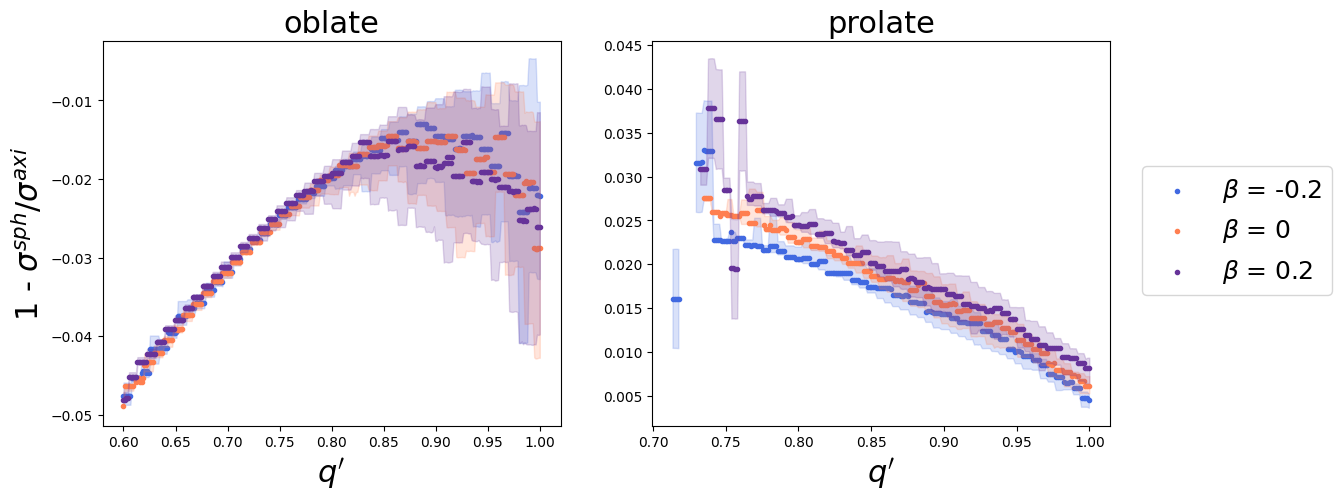

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (13, 5))
color = ['royalblue', 'coral', 'rebeccapurple']
legend_handle = []
for i in range(3):
    b_med = np.array([x[1] for x in pcs_list_oblate[i]])
    b_low = np.array([x[0] for x in pcs_list_oblate[i]])
    b_hi = np.array([x[2] for x in pcs_list_oblate[i]])
    q_obs = qobs_sample

    sorted_indices = np.argsort(q_obs)
    q_obs = q_obs[sorted_indices]
    b_med = b_med[sorted_indices]
    b_low = b_low[sorted_indices]
    b_hi = b_hi[sorted_indices]

    legend_handle.append(axes[0].scatter(qobs_sample, b_med, marker = '.', label = r'$\beta$ = {}' .format(beta_const_list[i]), color = color[i]))
    axes[0].fill_between(q_obs, b_low, b_hi, alpha = 0.2, color = color[i])

    b_med = np.array([x[1] for x in pcs_list_prolate[i]])
    b_low = np.array([x[0] for x in pcs_list_prolate[i]])
    b_hi = np.array([x[2] for x in pcs_list_prolate[i]])
    q_obs = qobs_sample

    sorted_indices = np.argsort(q_obs)
    q_obs = q_obs[sorted_indices]
    b_med = b_med[sorted_indices]
    b_low = b_low[sorted_indices]
    b_hi = b_hi[sorted_indices]

    axes[1].scatter(qobs_sample, b_med, marker = '.', label = r'$\beta$ = {}' .format(beta_const_list[i]), color = color[i])
    axes[1].fill_between(q_obs, b_low, b_hi, alpha = 0.2, color = color[i])

axes[0].set_title('oblate', size = 22)
axes[1].set_title('prolate', size = 22) 
axes[0].set_xlabel("$q'$", size = 22)
axes[1].set_xlabel("$q'$", size = 22)
axes[0].set_ylabel(r'1 - $\sigma^{sph} / \sigma^{axi}$', size = 22)
fig.legend(prop = {'size': 18}, bbox_to_anchor = (1.08, 0.5), loc = 'center right', handles=legend_handle)
plt.show()

Now marginalizing over $f$ by drawing from the $f$ PDF.

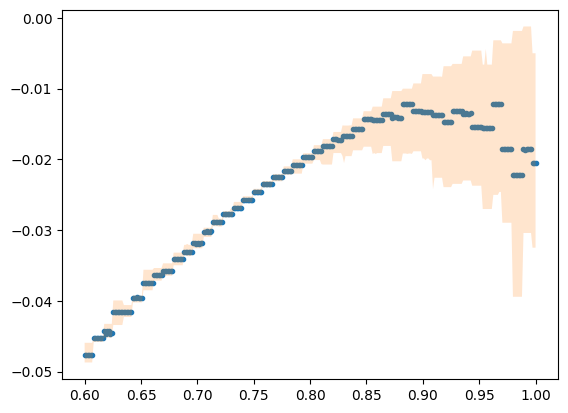

In [9]:
from scipy.interpolate import interp1d

def DrawFromPDF(x_pdf, y_pdf, num):
    cdf = np.cumsum(y_pdf) / np.cumsum(y_pdf)[-1]
    inv_cdf = interp1d(x=cdf, y=x_pdf, fill_value='extrapolate')
    random_num = np.random.uniform(0, 1, num)
    var_rm = inv_cdf(random_num)

    return var_rm

# for each q', draw from the f PDF many times
f_draw = DrawFromPDF(f_array, likelihood_combined, 1000)
f_draw = np.sort(f_draw)
bias_all = []

for ind in range(len(qobs_sample)):
    q_test = qobs_sample[ind]
    bias_ob = bias_list_oblate[0][ind]
    bias_pro = bias_list_prolate[0][ind]

    bias_all_qobs = np.array([])
    for f in f_draw:
        # for each f, combine the bias
        num_draw_from_oblate = round(f * (len(bias_ob) + len(bias_pro)))
        num_draw_from_prolate = (len(bias_ob) + len(bias_pro)) - num_draw_from_oblate
        try:
            combined = np.concatenate([np.random.choice(bias_ob, num_draw_from_oblate, replace=True),
                                np.random.choice(bias_pro, num_draw_from_prolate, replace=True)])
        except:
            combined = np.concatenate([np.random.choice(bias_ob, num_draw_from_oblate + num_draw_from_prolate, replace=True)]) # when for prolate there is no corresponding q'
        bias_all_qobs = np.concatenate([bias_all_qobs, combined])

    bias_all.append(np.quantile(bias_all_qobs, [0.16, 0.5, 0.84]))


b_med = np.array([x[1] for x in bias_all])
b_low = np.array([x[0] for x in bias_all])
b_hi = np.array([x[2] for x in bias_all])
plt.scatter(qobs_sample, b_med, marker = '.')
plt.fill_between(qobs_sample, b_low, b_hi, alpha = 0.2)
plt.show()